### `Instructions`

**Lab sessions aim to:**<br>
* Show and reinforce how models and ideas presented in class are used in practice.<br>
* Help you gather hands-on machine learning skills.<br>

**Lab sessions are:**<br>
* Learning environments where you work with Jupyter notebooks and where you can get support from TAs and fellow students.<br> 
* Not graded and do not have to be submitted. 

### `Use of AI tools`
AI tools, such as ChatGPT and Co-pilot, are great tools to assist with programming. Moreover, in your later careers you will work in a world where such tools are widely available. As such, we **encourage** you to use AI tools **effectively** (both in the lab sessions and assignments). However, be careful not to overestimate the capacity of AI tools! AI tools cannot replace you: you still have to conceptualise the problem, dissect it and structure it, to conduct proper analysis and modelling. We recommend being especially **reticent** with using AI tools for the more conceptual and reflective oriented questions. 
### `Google Colab workspace set-up`

Uncomment the following cells code lines if you are running this notebook on Colab

In [217]:
#!git clone https://github.com/TPM034A/Q2_2025
#!pip install -r Q2_2025/requirements_colab.txt
#!mv "/content/Q2_2025/Lab_sessions/lab_session_04/data" /content/data

In [218]:
# Import required Python packages and modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt


# Import selected functions and classes from Python packages
from os import getcwd
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Basic libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# ML tools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer,log_loss

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor

# Visualization libraries
import seaborn as sns
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.ticker import FixedLocator
from sklearn.tree import plot_tree
from branca.element import Figure

# Other libraries
from pathlib import Path
from shapely.geometry import Point
from PIL import Image
import pickle
from sklearn.preprocessing import StandardScaler

### `Application: Explaining the prediction of the next 24-hour electricity load` <br>

#### **Introduction**
In this lab session we will train a Linear regression (LR) and a Random forest regressor (RF) to predict the **next 24-hour electricity load** of a household. We will then use the tools of Explainable AI, and in particular SHAP, to better understand how specific prediction are influenced by different features.

#### **Data**

1. `data/load.pkl`: A pickle file with a pandas.DataFrame of overall Wh hourly energy consumption of a household from the REFIT Electrical Load Measurements dataset, collected over a period of about two years.
2. `data/devices.pkl`: A pickle file with a pandas.DataFrame of normalized weather variables: `dwpt` is Dew Point (related to moisture), `rhum` is relative humidity, `temp` is temperature, `wdir` is wind direction, `wspd` is wind speed.


### Preparation

In [219]:
import pandas as pd

if False:
    load_df_orig = pd.read_pickle('original_data/load_df.pkl')
    load_df_orig.head()
    
    load_df['load'].to_pickle('data/load.pkl')
    
    load_df[['temp', 'dwpt', 'rhum', 'wdir', 'wspd']].to_pickle('data/weather.pkl')
    
    load_df = pd.read_pickle('original_data/load_df.pkl')
    load_df.head()
    
    load_df['Aggregate'].rename('load').to_pickle('data/load.pkl')
    
    prices_df = pd.read_pickle('original_data/price_df.pkl')
    prices_df.rename('price').to_pickle('../../Assignments/assignment_04/data/price.pkl')
    
    load_df = pd.read_pickle('original_data/load_df.pkl')
    load_df.columns
    
    devices = ['Toaster', 'Fridge-Freezer', 'Freezer',
           'Tumble Dryer', 'Dishwasher', 'Washing Machine', 'Television',
           'Microwave', 'Kettle']
    #load_df[devices] = (load_df[devices] > 1).astype(int)
    load_df['Load'] = load_df['Aggregate']
    load_df.head()
    load_df['Load'].to_pickle('../../Assignments/assignment_04/data/load.pkl')
    load_df[devices].to_pickle('../../Assignments/assignment_04/data/devices.pkl')
    load_df[['dwpt', 	'rhum', 	'temp', 	'wdir', 	'wspd']].to_pickle('../../Assignments/assignment_04/data/weather.pkl')
    
    load_df[['Aggregate', 'Toaster', 'Fridge-Freezer', 'Freezer',
           'Tumble Dryer', 'Dishwasher', 'Washing Machine', 'Television',
           'Microwave', 'Kettle']].to_pickle('../../Assignments/assignment_04/data/devices.pkl')

### Load and preprocess the datasets

### <span style="color:skyblue"> Q1: Use pd.read_pickle to load 'data/load.pkl'</span>
Check that you get a similar pd.Series:

```terminal
Time
2013-09-25 19:00:00    410.766578
2013-09-25 20:00:00    417.421053
2013-09-25 21:00:00    508.165821
```


In [220]:
# Code here your answer
time_data = pd.read_pickle('data/load.pkl')
type(time_data)
time_data.index[0]

Timestamp('2013-09-25 19:00:00')

### <span style="color:skyblue">Q2: How many observations does the dataset have? What is the overall time range?</span>

In [221]:
# Code here your answer
#we have 14752 entries



In [222]:
print(f'The time data goes from {time_data.index[0]} to {time_data.index[-1]}')

The time data goes from 2013-09-25 19:00:00 to 2015-06-02 10:00:00


### <span style="color:skyblue">Q3: Use pd.read_pickle to load 'data/weather.pkl'</span>
Check that you have a pd.DataFrame with columns
```python
['temp', 'dwpt', 'rhum', 'wdir', 'wspd']
```
and index equal to the load index

In [223]:
# Code here your answer
weather_data = pd.read_pickle('data/weather.pkl')
weather_data

,temp,dwpt,rhum,wdir,wspd
Time,,,,,
2013-09-25 19:00:00,0.833333,0.740741,0.774074,0.114286,0.230958
2013-09-25 20:00:00,0.750000,0.740741,0.733333,0.085714,0.186732
2013-09-25 21:00:00,0.833333,0.703704,0.737037,0.057143,0.319410
2013-09-25 22:00:00,0.833333,0.703704,0.737037,0.171429,0.452088
2013-09-25 23:00:00,0.916667,0.629630,0.703704,0.142857,0.503686
...,...,...,...,...,...
2015-06-02 06:00:00,0.916667,0.592593,0.666667,0.657143,0.547912
2015-06-02 07:00:00,0.916667,0.629630,0.703704,0.628571,0.636364
2015-06-02 08:00:00,0.833333,0.666667,0.700000,0.600000,0.724816


### <span style="color:skyblue">Q4: Add an "hour" column to the load df, corresponding to the integer hour of the index</span>
e.g. 2013-09-25 19:00:00 --> 19

Hint: convert index into a pd.Series and use the .hour accessor

In [224]:
time_data=pd.DataFrame(time_data)

In [225]:
time_data['hour'] = time_data.index[:].hour

In [226]:
time_data

,load,hour
Time,,
2013-09-25 19:00:00,410.766578,19
2013-09-25 20:00:00,417.421053,20
2013-09-25 21:00:00,508.165821,21
2013-09-25 22:00:00,264.194492,22
2013-09-25 23:00:00,296.035836,23
...,...,...
2015-06-02 06:00:00,289.996047,6
2015-06-02 07:00:00,331.052326,7
2015-06-02 08:00:00,618.761996,8


### <span style="color:skyblue">Q5: Add 3 columns to the load df</span>
load_lag_24, load_lag_48 and load_lag_72 corresponding to the value of load 24, 48 and 72 hourse before, respectively

Hint: use the .shift function

check as example the first five 21:00 samples to make sure you computed the lags correctly

In [227]:

time_data['load_lag_24'] = time_data['load'].shift(24)
time_data['load_lag_48'] = time_data['load'].shift(48)
time_data['load_lag_72'] = time_data['load'].shift(72)
time_data

,load,hour,load_lag_24,load_lag_48,load_lag_72
Time,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN
...,...,...,...,...,...
2015-06-02 06:00:00,289.996047,6,291.517241,269.319688,280.325581
2015-06-02 07:00:00,331.052326,7,295.352031,396.426357,348.596117
2015-06-02 08:00:00,618.761996,8,648.710680,699.847784,548.675728


### <span style="color:skyblue">Q6: Add 7 dummy columns</span>

Each one with value 0 or 1 for each day of the week of the corresponding index, named "day_name_monday", "day_name_tuesday", ... , "day_name_saturday" (skipping Sunday)

Hint: use index.dayofweek and pd.get_dummies

check as example the first seven 21:00 samples to make sure you computed the day_name columns correctly

In [228]:
# Code here your answer
# time_data.drop(time_data.index[-4:-1], inplace=True)

In [229]:
# time_data.index = pd.to_datetime(time_data.index)
time_data

,load,hour,load_lag_24,load_lag_48,load_lag_72
Time,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN
...,...,...,...,...,...
2015-06-02 06:00:00,289.996047,6,291.517241,269.319688,280.325581
2015-06-02 07:00:00,331.052326,7,295.352031,396.426357,348.596117
2015-06-02 08:00:00,618.761996,8,648.710680,699.847784,548.675728


In [230]:
# Extract day names from the datetime index
day_names = time_data.index.day_name()

# Create dummy variables
day_dummies = pd.get_dummies(day_names, prefix='day_name')

# Remove Sunday as required by exercise
day_dummies = day_dummies.drop(columns=['day_name_Sunday'])

day_dummies.index = time_data.index
# Add to your time_data dataframe
time_data = time_data.join(day_dummies)

time_data


,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN,False,False,False,False,False,True
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN,False,False,False,False,False,True
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN,False,False,False,False,False,True
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN,False,False,False,False,False,True
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,289.996047,6,291.517241,269.319688,280.325581,False,False,False,False,True,False
2015-06-02 07:00:00,331.052326,7,295.352031,396.426357,348.596117,False,False,False,False,True,False
2015-06-02 08:00:00,618.761996,8,648.710680,699.847784,548.675728,False,False,False,False,True,False


In [231]:
bool_cols = time_data.select_dtypes(include='bool').columns
time_data[bool_cols] = time_data[bool_cols].astype(int)

In [232]:
# time_data.drop(columns = [0,1,2,3,4,5,6],inplace = True)

In [233]:
time_data

,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,289.996047,6,291.517241,269.319688,280.325581,0,0,0,0,1,0
2015-06-02 07:00:00,331.052326,7,295.352031,396.426357,348.596117,0,0,0,0,1,0
2015-06-02 08:00:00,618.761996,8,648.710680,699.847784,548.675728,0,0,0,0,1,0


In [234]:
bool_cols = [c for c in time_data.columns if c.startswith("day_name_")]

# Convert "True"/"False" strings → real booleans
time_data[bool_cols] = time_data[bool_cols].replace({True: 1, False: 0})

In [235]:
time_data

,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,
2013-09-25 19:00:00,410.766578,19,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 20:00:00,417.421053,20,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 21:00:00,508.165821,21,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 22:00:00,264.194492,22,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 23:00:00,296.035836,23,NaN,NaN,NaN,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,289.996047,6,291.517241,269.319688,280.325581,0,0,0,0,1,0
2015-06-02 07:00:00,331.052326,7,295.352031,396.426357,348.596117,0,0,0,0,1,0
2015-06-02 08:00:00,618.761996,8,648.710680,699.847784,548.675728,0,0,0,0,1,0


### <span style="color:skyblue">Q7: Merge the weather and the load df</span>
Hint: use df.join

In [236]:
# Code here your answer
df = weather_data.join(time_data)
df

,temp,dwpt,rhum,wdir,wspd,load,hour,load_lag_24,load_lag_48,load_lag_72,day_name_Friday,day_name_Monday,day_name_Saturday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
Time,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.833333,0.740741,0.774074,0.114286,0.230958,410.766578,19,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 20:00:00,0.750000,0.740741,0.733333,0.085714,0.186732,417.421053,20,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 21:00:00,0.833333,0.703704,0.737037,0.057143,0.319410,508.165821,21,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 22:00:00,0.833333,0.703704,0.737037,0.171429,0.452088,264.194492,22,NaN,NaN,NaN,0,0,0,0,0,1
2013-09-25 23:00:00,0.916667,0.629630,0.703704,0.142857,0.503686,296.035836,23,NaN,NaN,NaN,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,0.916667,0.592593,0.666667,0.657143,0.547912,289.996047,6,291.517241,269.319688,280.325581,0,0,0,0,1,0
2015-06-02 07:00:00,0.916667,0.629630,0.703704,0.628571,0.636364,331.052326,7,295.352031,396.426357,348.596117,0,0,0,0,1,0
2015-06-02 08:00:00,0.833333,0.666667,0.700000,0.600000,0.724816,618.761996,8,648.710680,699.847784,548.675728,0,0,0,0,1,0


### <span style="color:skyblue">Q8: Plot the load of a single day, e.g. 2013-12-12</span>
Does the shape make sense?

In [237]:
# Code here your answer

df.index = pd.to_datetime(df.index)

In [238]:
one_day = df[df.index.date == pd.to_datetime('2013-12-12').date()]

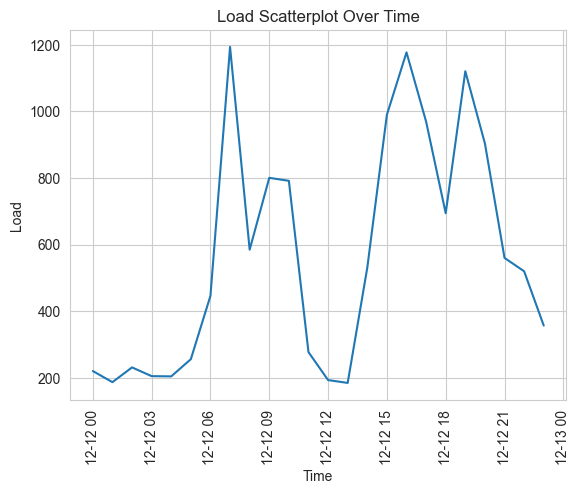

In [239]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(one_day.index, one_day.load)
plt.xlabel("Time")
plt.xticks(rotation=90)
plt.ylabel("Load")
plt.title("Load Scatterplot Over Time")
plt.show()

### <span style="color:skyblue">Q9: Plot the average and confidence interval of hourly load for weekdays vs weekends from '2013-11-01' onwards</span>
Hint: use seaborn.lineplot

Do you observe any difference?

In [240]:
midweek = df[df.index.dayofweek < 5]['load']


In [241]:
import numpy as np
midweek_mean = midweek.groupby(midweek.index.hour).mean()
midweek_std = midweek.groupby(midweek.index.hour).std()

sem_midweek = midweek_std/ np.sqrt(midweek_mean)

ci_upper_midweek = midweek_mean + 1.96 * sem_midweek
ci_lower_midweek = midweek_mean - 1.96 * sem_midweek

In [242]:
weekend = df[df.index.dayofweek >= 5]['load']
weekend

Time
2013-09-28 00:00:00    218.741056
2013-09-28 01:00:00    631.034483
2013-09-28 02:00:00    548.613445
2013-09-28 03:00:00    260.560606
2013-09-28 04:00:00    331.000000
                          ...    
2015-05-31 19:00:00    434.976517
2015-05-31 20:00:00    490.944444
2015-05-31 21:00:00    382.743191
2015-05-31 22:00:00    377.402321
2015-05-31 23:00:00    274.697674
Name: load, Length: 4224, dtype: float64

In [243]:
weekend_mean = weekend.groupby(weekend.index.hour).mean()
weekend_std = weekend.groupby(weekend.index.hour).std()

sem_weekend = weekend_std/ np.sqrt(weekend_mean)

ci_upper_weekend = weekend_mean + 1.96 * sem_weekend
ci_lower_weekend = weekend_mean - 1.96 * sem_weekend

In [244]:
weekend_mean

Time
0     305.046433
1     300.692988
2     284.391107
3     277.994632
4     279.433936
5     280.786262
6     325.788783
7     486.330488
8     523.573823
9     579.438859
10    552.136655
11    557.635972
12    578.704974
13    591.795190
14    566.598919
15    642.683145
16    634.421616
17    671.435010
18    611.604284
19    574.810819
20    557.345996
21    517.293205
22    407.937814
23    319.594255
Name: load, dtype: float64

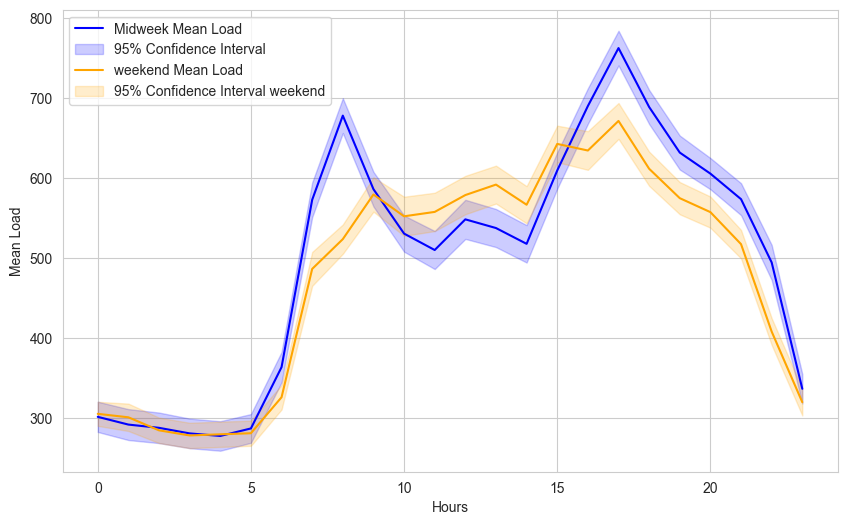

In [245]:
fig, ax = plt.subplots(figsize=(10,6))
# Mean line
ax.plot(midweek_mean.index, midweek_mean, label="Midweek Mean Load", color="blue")
ax.fill_between(midweek_mean.index, ci_lower_midweek, ci_upper_midweek, color="blue", alpha=0.2, label="95% Confidence Interval")
ax.plot(weekend_mean.index, weekend_mean, label="weekend Mean Load", color="orange")
ax.fill_between(weekend_mean.index, ci_lower_weekend, ci_upper_weekend, color="orange", alpha=0.2, label="95% Confidence Interval weekend")
ax.set_xlabel("Hours")
ax.set_ylabel("Mean Load")
ax.legend()


### <span style="color:skyblue">Q10: Add dummies "hour_1", "hour_2", ... "hour_23" (skipping "hour_0"), equal to 1 for the corresponding index hour</span>
Hint: use pd.get_dummies

In [246]:
# Code here your answer
dummies = pd.get_dummies(df.index.hour)
dummies = dummies.replace({True: 1, False: 0})
dummies.index = df.index
df = df.join(dummies)
df


C:\Users\piete\AppData\Local\Temp\ipykernel_26276\4231789345.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dummies = dummies.replace({True: 1, False: 0})


,temp,dwpt,rhum,wdir,wspd,load,hour,load_lag_24,load_lag_48,load_lag_72,...,14,15,16,17,18,19,20,21,22,23
Time,,,,,,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.833333,0.740741,0.774074,0.114286,0.230958,410.766578,19,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2013-09-25 20:00:00,0.750000,0.740741,0.733333,0.085714,0.186732,417.421053,20,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2013-09-25 21:00:00,0.833333,0.703704,0.737037,0.057143,0.319410,508.165821,21,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
2013-09-25 22:00:00,0.833333,0.703704,0.737037,0.171429,0.452088,264.194492,22,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
2013-09-25 23:00:00,0.916667,0.629630,0.703704,0.142857,0.503686,296.035836,23,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-02 06:00:00,0.916667,0.592593,0.666667,0.657143,0.547912,289.996047,6,291.517241,269.319688,280.325581,...,0,0,0,0,0,0,0,0,0,0
2015-06-02 07:00:00,0.916667,0.629630,0.703704,0.628571,0.636364,331.052326,7,295.352031,396.426357,348.596117,...,0,0,0,0,0,0,0,0,0,0
2015-06-02 08:00:00,0.833333,0.666667,0.700000,0.600000,0.724816,618.761996,8,648.710680,699.847784,548.675728,...,0,0,0,0,0,0,0,0,0,0


In [247]:
df = df.drop(columns = 0)

In [248]:
for i in range(1,24):
    df.rename(columns = {i: f'hour_{i}'}, inplace = True)

### Train a linear regression model

### <span style="color:skyblue">Q11: Train a linear regression model to predict load of 2014-12-12 based on features computed above.</span>
Use the period 2013-11-01 to 2014-12-11 for training.

In [249]:
df_linreg = df.dropna()

In [250]:
train = df_linreg[(df_linreg.index > pd.to_datetime('2013-11-01')) &
   (df_linreg.index < pd.to_datetime('2014-12-11'))]
train_columns = train.columns.to_list()
train_columns.remove('load')
X_train = train[train_columns]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=train_columns)
X_train_scaled



,temp,dwpt,rhum,wdir,wspd,hour,load_lag_24,load_lag_48,load_lag_72,day_name_Friday,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.905543,-0.153458,0.354296,0.269612,0.434127,-1.521662,-1.062913,-1.111564,-0.507291,2.449139,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979
1,0.905543,-0.153458,0.354296,0.383905,0.434127,-1.377450,-0.851255,-0.897015,-0.913035,2.449139,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979
2,0.905543,-0.153458,0.354296,0.383905,0.434127,-1.233238,-1.045849,-1.022829,-1.025670,2.449139,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979
3,0.834583,-0.350952,0.054263,0.383905,0.184383,-1.089026,-0.915513,-0.898297,-0.987127,2.449139,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979
4,0.408825,-0.153458,0.054263,0.269612,0.434127,-0.944814,-0.984064,-1.016768,-0.971093,2.449139,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8141,-0.797491,-0.943434,-1.695926,0.498198,2.836433,1.074155,2.250910,1.985298,0.124653,-0.408307,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,4.762377,-0.209979,-0.209979,-0.209979,-0.209979
8142,-0.016934,-1.140927,-1.420896,0.498198,-2.003857,1.218367,1.436985,1.510177,0.414355,-0.408307,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,4.762377,-0.209979,-0.209979,-0.209979
8143,-0.016934,-1.140927,-1.420896,0.383905,1.290395,1.362579,1.668536,1.216539,0.484537,-0.408307,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,4.762377,-0.209979,-0.209979
8144,-0.442693,-1.140927,-1.695926,0.383905,1.766099,1.506791,0.779120,1.467113,-0.306906,-0.408307,...,-0.207739,-0.207739,-0.208701,-0.209979,-0.209979,-0.209979,-0.209979,-0.209979,4.762377,-0.209979


In [251]:
Y_train = train['load']

In [252]:
date = pd.to_datetime('2014-12-12')
test = df_linreg[(df_linreg.index >= date) & (df_linreg.index < date + pd.Timedelta(days=1))]
test


,temp,dwpt,rhum,wdir,wspd,load,hour,load_lag_24,load_lag_48,load_lag_72,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
Time,,,,,,,,,,,,,,,,,,,,,
2014-12-12 00:00:00,0.902778,0.370370,0.440741,0.571429,0.680590,223.779245,0,438.064151,212.610586,199.846729,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 01:00:00,0.902778,0.370370,0.440741,0.571429,0.680590,244.140977,1,221.075614,223.000000,267.100746,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 02:00:00,0.902778,0.370370,0.440741,0.542857,0.636364,198.106343,2,245.514178,241.454717,201.481343,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 03:00:00,0.902778,0.370370,0.440741,0.514286,0.503686,270.667293,3,291.001887,200.243396,252.794007,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 04:00:00,1.000000,0.370370,0.477778,0.542857,0.186732,202.894737,4,252.093985,254.615819,218.009416,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 05:00:00,0.902778,0.370370,0.440741,0.828571,0.319410,248.891386,5,255.973734,201.415094,204.671028,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 06:00:00,0.902778,0.333333,0.403704,0.742857,0.680590,298.843691,6,327.595506,300.333333,305.396617,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 07:00:00,0.902778,0.333333,0.403704,0.714286,0.680590,412.056075,7,452.724719,521.594340,445.684112,...,0,0,0,0,0,0,0,0,0,0
2014-12-12 08:00:00,0.902778,0.333333,0.403704,0.742857,0.680590,1194.289179,8,1007.668539,1014.521657,1082.654784,...,0,0,0,0,0,0,0,0,0,0


In [253]:
test_columns = test.columns.to_list()
test_columns.remove('load')
X_test = test[test_columns]
X_test_scaled  = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test_columns)
Y_test = test['load']


In [254]:
# Code here your answer
# Set the seed number for reproducibility. It governs which data points go to the test set and which go to the training set
rs = 12345


# Create linear regression object
regr = LinearRegression(fit_intercept = True)

# Split the data in a train and test set
# X_train, X_test, Y_train, Y_test = train_test_split(X_lin, Y, test_size=0.25,random_state = rs)

# Fit the model on the training data
regr.fit(X_train_scaled,Y_train)

# Evaluate the model generalisation performance on the Train and Test data sets
Y_pred_train = regr.predict(X_train_scaled)
mse_train = mean_squared_error(Y_train,Y_pred_train)
R2_train = r2_score(Y_train,Y_pred_train)

Y_pred_test = regr.predict(X_test_scaled)
mse_test  = mean_squared_error(Y_test, Y_pred_test)
R2_test = r2_score(Y_test,Y_pred_test)

# Print results
print('Results linear multiple regression model')
print(f'Mean Squared Error Train | Test: \t{mse_train:>7.4f}\t|  {mse_test:>7.4f}')
print(f'R2                 Train | Test: \t{R2_train:>7.4f}\t|  {R2_test:>7.4f}\n')
print('Weights')
print(f'Intercept: \t\t\t {regr.intercept_:>7.4f}')
for n in range(len(regr.coef_)):
    print(f'Weight_{X_train.keys()[n]:10s} \t\t {regr.coef_[n]:>7.4f}')

Results linear multiple regression model
Mean Squared Error Train | Test: 	53938.4475	|  46646.6107
R2                 Train | Test: 	 0.3123	|   0.5550

Weights
Intercept: 			 491.0405
Weight_temp       		  1.7276
Weight_dwpt       		 -0.4617
Weight_rhum       		 -24.6504
Weight_wdir       		 -4.1926
Weight_wspd       		  2.3140
Weight_hour       		 47.5238
Weight_load_lag_24 		 37.6158
Weight_load_lag_48 		 40.7208
Weight_load_lag_72 		 28.7579
Weight_day_name_Friday 		  1.9463
Weight_day_name_Monday 		 18.0699
Weight_day_name_Saturday 		 -1.3494
Weight_day_name_Thursday 		 -0.0401
Weight_day_name_Tuesday 		 14.2667
Weight_day_name_Wednesday 		  2.1709
Weight_hour_1     		 -2.2831
Weight_hour_2     		 -4.1687
Weight_hour_3     		 -6.5450
Weight_hour_4     		 -8.4252
Weight_hour_5     		 -8.8959
Weight_hour_6     		 -1.1320
Weight_hour_7     		 26.8531
Weight_hour_8     		 25.9380
Weight_hour_9     		 17.3694
Weight_hour_10    		 11.7589
Weight_hour_11    		 11.9757
Weight_hour_12    

### <span style="color:skyblue">Q12: Compute the root mean squared error</span>

In [255]:
# Code here your answer

### Explain a LR model with SHAP

### <span style="color:skyblue">Q13: Plot the SHAP values for the test set (load values for the hours of the day 2014-12-12)</span>
Hint: use shap.Explainer and shap.plots.beeswarm

In [256]:
# Code here your answer
import shap
explainer = shap.Explainer(regr, X_train_scaled)

In [257]:
shap_values = explainer(X_test_scaled)


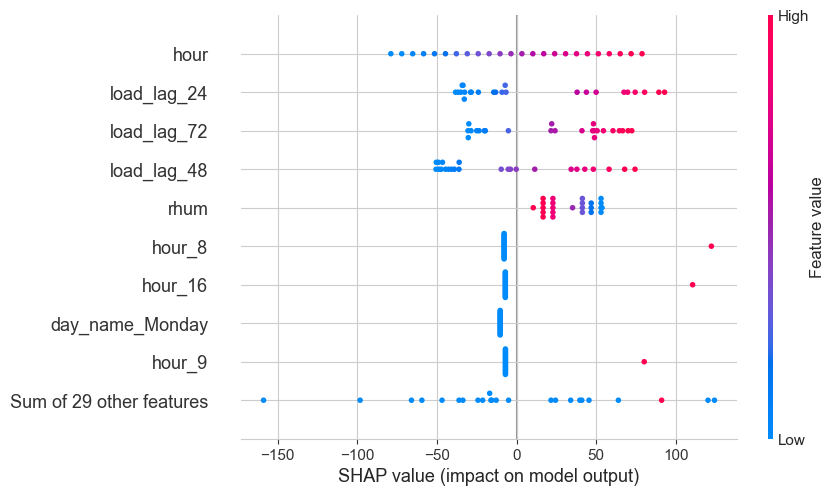

In [258]:
shap.plots.beeswarm(shap_values)

In [259]:
# plt.plot(X_test['hour'], Y_test['load'])
Y_train

Time
2013-11-01 01:00:00    199.041667
2013-11-01 02:00:00    214.123333
2013-11-01 03:00:00    229.613333
2013-11-01 04:00:00    217.195000
2013-11-01 05:00:00    276.385000
                          ...    
2014-12-10 19:00:00    842.568401
2014-12-10 20:00:00    783.505682
2014-12-10 21:00:00    879.476460
2014-12-10 22:00:00    808.312618
2014-12-10 23:00:00    512.013109
Name: load, Length: 8146, dtype: float64

### Train a Random Forest Regressor

### <span style="color:skyblue">Q14: Train a random forest regressor model to predict load of 2014-12-12.</span>
- Use the period 2013-11-01 to 2014-12-11 for training.
- Do not use the dummies computed above. Use the following features instead:
```python
['hour', 'load_lag_24', 'load_lag_48', 'load_lag_72', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'weekday']
````
*where hour and weekday are int*

In [260]:
# Code here your answer
train['weekday'] = train.index.weekday
X_train_tree = train[['hour', 'load_lag_24', 'load_lag_48', 'load_lag_72', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'weekday']]
Y_train_tree = train['load']
test['weekday'] = test.index.weekday
X_test_tree = test[['hour', 'load_lag_24', 'load_lag_48', 'load_lag_72', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'weekday']]
Y_test_tree = test['load']

C:\Users\piete\AppData\Local\Temp\ipykernel_26276\2279089828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.weekday
C:\Users\piete\AppData\Local\Temp\ipykernel_26276\2279089828.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['weekday'] = test.index.weekday


In [261]:
# Create RF object for hyperparameter tuning
rf_gs = RandomForestRegressor(n_estimators=50,criterion= "squared_error",random_state=5)

# Define the hyperparameter search space
hyperparameter_space = {
    'max_depth': [5, 20],
    'max_leaf_nodes': [500,2500],
    # 'min_samples_leaf': [15],     # Not tuned here too avoid long computation time
    # 'max_features':[0.7]          # Not tuned here too avoid long computation time
    }

# Create scoring function
scorer = make_scorer(mean_squared_error, greater_is_better = False)

# Create the grid_search object, with using the MLP classifier
folds = 5 # Number of cross validation splits
rf_gridsearch = GridSearchCV(rf_gs, hyperparameter_space, n_jobs=-1, cv=folds, scoring=scorer, return_train_score=True)

In [262]:
# if the model RF_gridsearch.pickle does not exist, conduct the gridsearch, else load the grid_search object
if not Path('RF_gridsearch.pickle').exists():

    # Fit the grid search object to the training data
    # Note that this is computationally expensive!
    # It may take up to 5 minutes, since multiple models need to be trained multiple times
    rf_gridsearch.fit(X_train_tree, Y_train_tree)

    # Save the trained grid_search object
    with open('RF_gridsearch.pickle', 'wb') as f:
        pickle.dump(rf_gridsearch, f)
else:
    # Load the trained grid_search object
    with open('RF_gridsearch.pickle', 'rb') as f:
        rf_gridsearch = pickle.load(f)

# Print the best parameters
print('Best parameters:')
print(f'Tuned hyperparameters:\n{rf_gridsearch.best_params_}')
print(f'Mean Squared Error:\t{(-rf_gridsearch.best_score_):0.3f}')

Best parameters:
Tuned hyperparameters:
{'max_depth': 5, 'max_leaf_nodes': 500}
Mean Squared Error:	60728.883


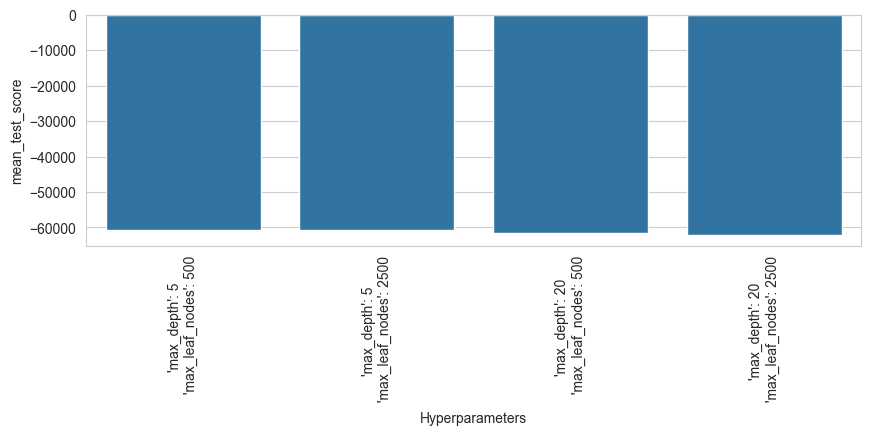

In [263]:
# Create a dataframe from the results
df_results = pd.DataFrame(rf_gridsearch.cv_results_)

# Extract relevant columns
df_results = df_results[['params', 'mean_test_score', 'mean_train_score']]

# Display the top performing models in a plot
top_models = df_results.sort_values(by='mean_test_score', ascending=False)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 3))

# Convert the dict row names to a list of strings, and replace the commas with newlines
param_list = [str(dict_) for dict_ in top_models['params']]
param_list = [param.replace(',', '\n') for param in param_list]
param_list = [param.replace('{', '')   for param in param_list]
param_list = [param.replace('}', '')   for param in param_list]

# Create a barplot
sns.barplot(x= param_list, y=top_models['mean_test_score'], ax=ax)

# Set the x-axis labels to the parameter list
ax.set_xlabel('Hyperparameters')

ax.xaxis.set_major_locator(FixedLocator(range(len(param_list))))
ax.set_xticklabels(param_list, rotation=90)

# Show the plot
plt.show()

In [264]:
def eval_regression_perf(model, X_train, X_test, Y_train, Y_test):

    # Make prediction with the trained model
    Y_pred_train = model.predict(X_train)
    Y_pred_test = model.predict(X_test)

    # Create a function that computes the MSE, MAE, and R2
    def perfs(Y,Y_pred):
        mse = mean_squared_error(Y,Y_pred)
        mae = mean_absolute_error(Y,Y_pred)
        R2 = r2_score(Y,Y_pred)
        return mse,mae,R2

    # Apply the perfs function to the train and test data sets
    mse_train, mae_train, r2_train = perfs(Y_train,Y_pred_train)
    mse_test,  mae_test , r2_test  = perfs(Y_test,Y_pred_test)

    # Print results
    print('Performance')
    print(f'Mean Squared  Error Train | Test: \t{mse_train:>7.4f}\t|  {mse_test:>7.4f}')
    print(f'Mean Absolute Error Train | Test: \t{mae_train:>7.4f}\t|  {mae_test:>7.4f}')
    print(f'R2                  Train | Test: \t{ r2_train:>7.4f}\t|  {r2_test:>7.4f}\n')

In [265]:
# Set the hyperparameters of the Random Forest to the best values found, e.g.

max_depth = rf_gridsearch.best_params_['max_depth']
max_leaf_nodes = rf_gridsearch.best_params_['max_leaf_nodes']
max_features = 0.7
min_samples_leaf = 15

# Create the Random Forest object with the best hyperparameters
rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, max_features=max_features, max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_samples_leaf, random_state=0,n_jobs=-1)

# Train the Randon Forest
rf.fit(X_train_tree,Y_train_tree)

# Evaluate the performance of the hyperparameter optimised RF model
eval_regression_perf(rf,X_train_tree,X_test_tree, Y_train_tree, Y_test_tree)

Performance
Mean Squared  Error Train | Test: 	50903.0072	|  44737.9612
Mean Absolute Error Train | Test: 	168.8104	|  151.8453
R2                  Train | Test: 	 0.3510	|   0.5732



### <span style="color:skyblue">Q15: What is the root mean squared error for the test set? Does the accuracy improve with respect to the linear model? </span>

In [266]:
# Code here your answer
# RMS is 44759, with the linear model is was 46646.6107, so it improved slightly.

### Explain a RF model with SHAP

### <span style="color:skyblue">Q16: Respond the following questions: </span>
- What is the expected energy consumption knowing the weekday?
- What is the weekday with the highest/lowest expected consumption?

Hint: use shap.partial_dependence_plot

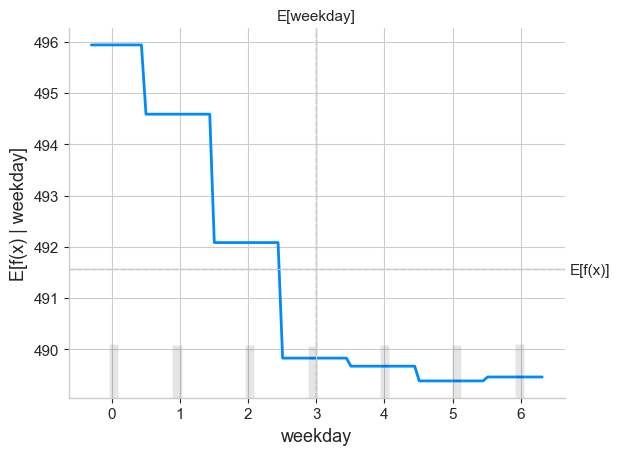

In [267]:
shap.partial_dependence_plot(
    "weekday",
    rf.predict,
    X_train_tree,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

### <span style="color:skyblue">Q17: Compare with the mean load of the train set grouped by weekday: are they different? If so, why?</span>

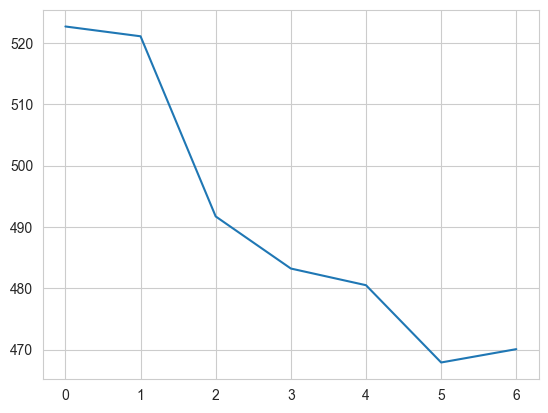

In [268]:
# Code here your answer
plt.plot(train.groupby('weekday')['load'].mean())

### <span style="color:skyblue">Q18: What is the expected energy consumption knowing the hour? What about temperature? Does the model behavior make sense?</span>

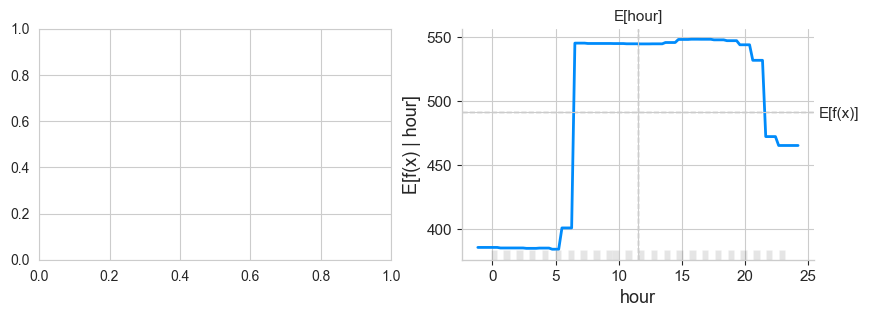

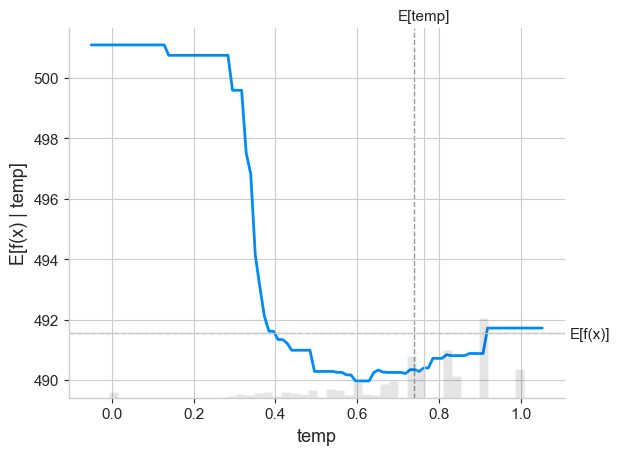

In [269]:
# Code here your answer
fig, ax = plt.subplots(1,2, figsize=(10, 3))

for i,j in enumerate(['hour', 'temp']):
    shap.partial_dependence_plot(
        j,
        rf.predict,
        X_train_tree,
        ice=False,
        model_expected_value=True,
        feature_expected_value=True,
        ax = ax[i]
    )

In [270]:
print('test')

test


### <span style="color:skyblue">Q19: Plot the SHAP values of each feature for each of the test samples.</span>
Hint: use shap.plots.beeswarm

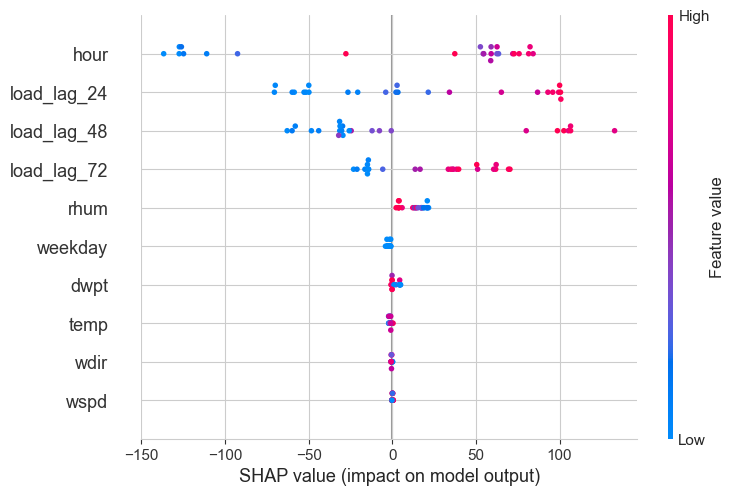

In [271]:
# Code here your answer
# Plot the SHAP values of each feature for each of the test samples.</span>
# Hint: use shap.plots.beeswarm

# 1. Create a TreeExplainer for your RF model
explainer = shap.TreeExplainer(rf)

# 2. Compute SHAP values for the *test* set
#    (for regression, explainer(...) returns a single Explanation object)
shap_values = explainer(X_test_tree)

# 3. Beeswarm plot: SHAP values of each feature for each test sample
shap.plots.beeswarm(shap_values)





### <span style="color:skyblue">Q20: What is the most predictive feature? What is the least predictive? How do you interpret it?</span>
Hint: use shap.plots.bar

In [272]:
# Code here your answer
#most predictive is the hour and the load lag of th previous days. So the hour of the day mostly determines the load, also the



### <span style="color:skyblue">Q21: Explain the 15:00 and 20:00 prediction of the test. What observations can you make? </span>
Hint: use shap.plots.waterfall

In [288]:
# Code here your answer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_tree)

In [299]:
row_15 = X_test_tree[X_test_tree['hour'] == 15].iloc[0]
row_20= X_test_tree[X_test_tree['hour'] == 20].iloc[0]


hour            15.000000
load_lag_24    294.355680
load_lag_48    267.305085
load_lag_72    729.729323
temp             0.736111
dwpt             0.296296
rhum             0.292593
wdir             0.714286
wspd             0.592138
weekday          4.000000
Name: 2014-12-12 15:00:00, dtype: float64


In [304]:
shap_15 = shap_values[X_test_tree['hour'] == 15][0]
shap_20 = shap_values[X_test_tree['hour'] == 20][0]

Time
2014-12-12 00:00:00    False
2014-12-12 01:00:00    False
2014-12-12 02:00:00    False
2014-12-12 03:00:00    False
2014-12-12 04:00:00    False
2014-12-12 05:00:00    False
2014-12-12 06:00:00    False
2014-12-12 07:00:00    False
2014-12-12 08:00:00    False
2014-12-12 09:00:00    False
2014-12-12 10:00:00    False
2014-12-12 11:00:00    False
2014-12-12 12:00:00    False
2014-12-12 13:00:00    False
2014-12-12 14:00:00    False
2014-12-12 15:00:00     True
2014-12-12 16:00:00    False
2014-12-12 17:00:00    False
2014-12-12 18:00:00    False
2014-12-12 19:00:00    False
2014-12-12 20:00:00    False
2014-12-12 21:00:00    False
2014-12-12 22:00:00    False
2014-12-12 23:00:00    False
Name: hour, dtype: bool

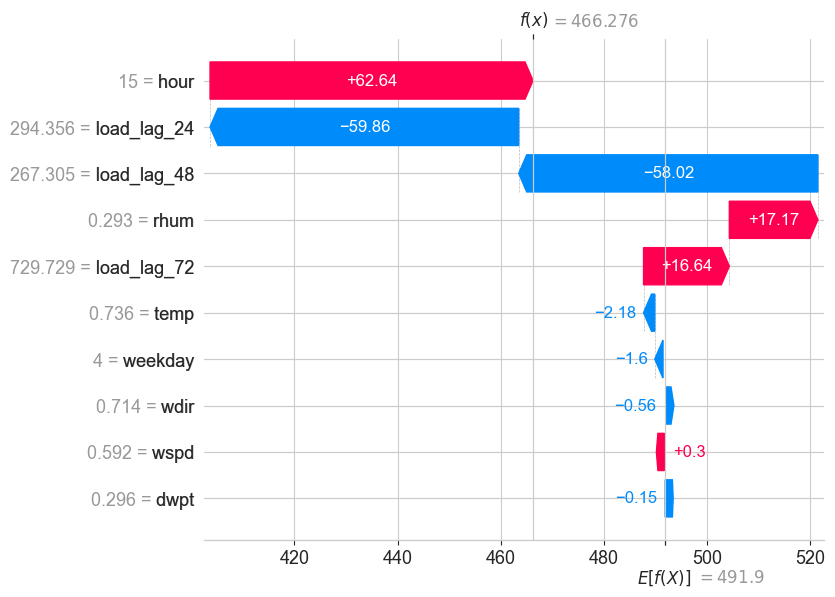

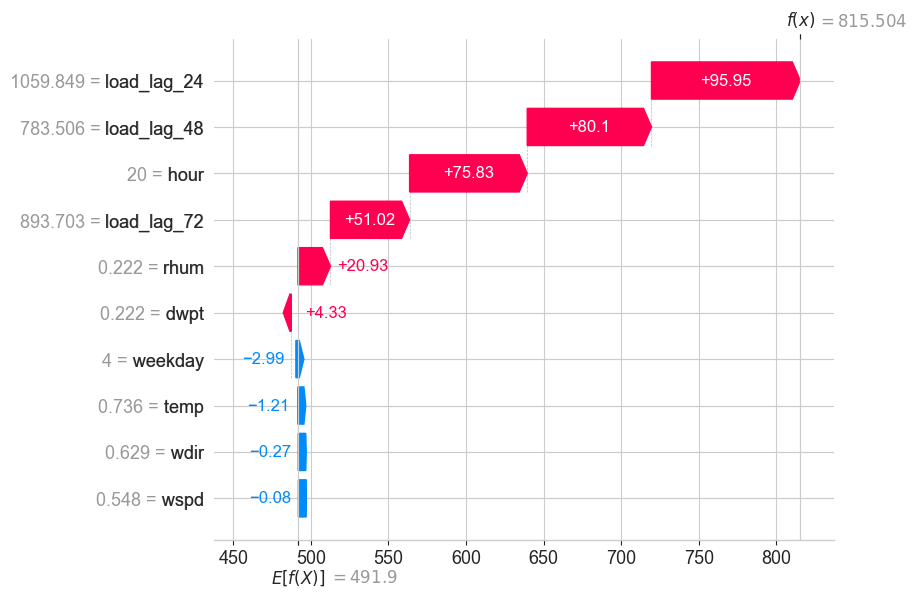

In [326]:
shap.plots.waterfall(shap.Explanation(
    values = shap_15,
    base_values = explainer.expected_value,
    data = row_15,
    feature_names = X_test_tree.columns
))

shap.plots.waterfall(shap.Explanation(
    values = shap_20,
    base_values = explainer.expected_value,
    data = row_20,
    feature_names = X_test_tree.columns
))

### Reflections

### <span style="color:skyblue">Q22: Reflect on how the information above could be useful for environmental reasons.</span>

In [59]:
# Code here your answer